In [1]:
#AL Feb-Jun 2017:  Emission angle and pol rotation
#Initial stuff to get field rotation as Post-Born paper, then new things.
#Using June 2017 CAMB master branch pycamb. Also uses files output of CAMB emission_angle branch (psi_zeta sources etc).
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
if os.name=='nt': sys.path.insert(0,r'c:\work\dist\git\camb\pycamb')

import camb
from camb import model, initialpower, postborn
from camb.bispectrum import threej
import scipy
from scipy.interpolate import RectBivariateSpline, UnivariateSpline
from scipy import optimize
from matplotlib import rcParams
import numpy as np
import copy

oldparams = rcParams

def setPlotStyle(usetex=False):
    params = {'backend': 'pdf',
              'axes.labelsize': 13,
              'font.size': 11,
              'legend.fontsize': 11,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12,
              'ytick.major.pad': 4,
              'xtick.major.pad': 6,
              'text.usetex': usetex}
    rcParams.update(params)

normtex=r'/2\pi\, [\mu  {\rm K}^2]'
save_files = False
print plt.matplotlib.__version__, camb.__version__

2.0.0 0.1.5


In [2]:
#Get matter power spectrum interpolation objects for fiducial model
kmax=100
lmax=20000
acc=2 
nz = 200*acc
pars = camb.CAMBparams()
tag=''   
pars.set_cosmology(H0=66.88, ombh2=0.02214, omch2=0.1207, tau=0.0581)
pars.InitPower.set_params(ns=0.9624, As=2.118e-9)
NL=True
results= camb.get_background(pars)
ztag = 'star'
chistar = results.conformal_time(0)- model.tau_maxvis.value
zmax = results.redshift_at_comoving_radial_distance(chistar)
PK = camb.get_matter_power_interpolator(pars, nonlinear=NL, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zmax)

print pars

WantCls = 1
WantTransfer = 0
WantScalars = 1
WantTensors = 0
WantVectors = 0
DoLensing = 1
want_zstar = 0
want_zdrag = 0
PK_WantTransfer = 0
NonLinear = 0
Want_CMB = 1
max_l = 2500
max_l_tensor = 600
max_eta_k = 5000.0
max_eta_k_tensor = 1200.0
omegab = 0.0494977078135
omegac = 0.26984522733
omegav = 0.67921473677
omegan = 0.00144232808677
H0 = 66.88
TCMB = 2.7255
YHe = 0.245286983807
num_nu_massless = 2.03066666667
num_nu_massive = 1
nu_mass_eigenstates = 1
share_delta_neff = 0
nu_mass_degeneracies = [1.0153333333333332, 0.0, 0.0, 0.0, 0.0]
nu_mass_fractions = [1.0, 0.0, 0.0, 0.0, 0.0]
nu_mass_numbers = [1, 0, 0, 0, 0]
scalar_initial_condition = 1
OutputNormalization = 1
AccuratePolarization = 1
AccurateBB = 0
AccurateReionization = 0
MassiveNuMethod = 3
InitPower:
  tensor_parameterization = 2
  nn = 1
  an = [0.9624, 1.0, 1.0, 1.0, 1.0]
  n_run = [0.0, 0.0, 0.0, 0.0, 0.0]
  n_runrun = [0.0, 0.0, 0.0, 0.0, 0.0]
  ant = [-0.0, 0.0, 0.0, 0.0, 0.0]
  nt_run = [-0.0, 0.0, 0.0, 0.0, 0.0]


In [3]:
#get CMB power
par_CMB=pars.copy()
par_CMB.InitPower.set_params(ns=0.9624, As=par_CMB.InitPower.ScalarPowerAmp[0], r=0.01)
par_CMB.set_for_lmax(lmax, lens_potential_accuracy=1, max_eta_k=100000)
par_CMB.WantTensors=True
par_CMB.max_l_tensor = 8000
par_CMB.max_eta_k_tensor  = 16000
raw_cl_camb=results.get_cmb_power_spectra(par_CMB, CMB_unit='muK', raw_cl=True)
cl_camb=results.get_cmb_power_spectra(CMB_unit='muK', raw_cl=False)
print cl_camb.keys()

['total', 'lens_potential', 'lensed_scalar', 'unlensed_scalar', 'unlensed_total', 'tensor']


In [4]:
# L(L+1)C_L
BB_tensor=cl_camb['tensor'][:,2]

Ref = cl_camb['lensed_scalar']
Ref_ls = np.arange(Ref.shape[0])
RefCE=Ref[:,1]
RefCB=Ref[:,2]

CPhi = cl_camb['lens_potential'][:,0]/4*2*np.pi #work with C_L^\kappa

#Raw unlensed CLs
CL_unlensed = raw_cl_camb['unlensed_scalar']
cl_ls = np.arange(CL_unlensed.shape[0]).astype(np.int)
CT = CL_unlensed[:,0]
CE = CL_unlensed[:,1]
print 'lmax cl = ', cl_ls[-1]

CEsp = UnivariateSpline(cl_ls, CE, s=0)

lmax cl =  17870


In [5]:
#Get field rotation power and B mode for comparison
#see arXiv:1605.05662

lsamp, clcurl = postborn.get_field_rotation_power_from_PK(pars, PK, chistar, lmax, acc=acc)

In [6]:
#sampling in L
lsall = np.arange(2,lmax+1, dtype=np.float64)
ls = np.hstack((np.arange(2, 400, 1),np.arange(401, 2600, 10//acc),
                np.arange(2650, lmax, 50//acc),np.arange(lmax,lmax+1))).astype(np.float64)


In [7]:
#Standard Limber first order power spectrum
def cl_kappa(chi_source, chi_source2=None):
    return postborn.cl_kappa_limber(results, PK, ls, nz, chi_source, chi_source2)


curl power 7.59002674505e-06 0.00275500031671
kappa power 0.0121768030104 0.110348552371


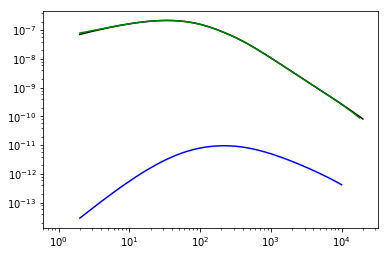

In [8]:
clkappa= cl_kappa(chistar)
    
plt.loglog(ls,clkappa, color='k')
plt.loglog(cl_ls,CPhi, color='g' ) #should agree well with limber clkappa
plt.loglog(lsamp,clcurl, color='b')
sp = UnivariateSpline(lsamp, (2*lsamp+1)/4/np.pi*clcurl, s=0)
var_curl =  sp.integral(lsamp[0],lsamp[-1])
sp = UnivariateSpline(ls, (2*ls+1)/4/np.pi*clkappa, s=0)
var_kappa = sp.integral(ls[0],ls[-1])
print 'curl power', var_curl, np.sqrt(var_curl)
print 'kappa power', var_kappa, np.sqrt(var_kappa)


In [9]:
#variance of rotation
def var_kappa(chi_source):
    chi_source = np.float64(chi_source)
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    win = (1/chis-1/chi_source)**2*chis**4
    nint = 200
    dlogk = (np.log(kmax)-np.log(1e-4))/nint
    var=0
    ks = np.exp(np.linspace(np.log(1e-4),np.log(kmax),num=nint))
    for i, (chi, z, dchi) in enumerate(zip(chis,zs, dchis)):
        var += win[i]*np.sum(ks**2*PK.P(z, ks, grid=False))*dchi
       
    return var*dlogk/(2*np.pi)

def var_omega(chi_source):
    chi_source = np.float64(chi_source)
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    win = (1/chis-1/chi_source)**2*chis**4
    nint = 200
    dlogk = (np.log(kmax)-np.log(1e-4))/nint
    var=0
    ks = np.exp(np.linspace(np.log(1e-4),np.log(kmax),num=nint))
    for i, (chi, z, dchi) in enumerate(zip(chis,zs, dchis)):
        var += win[i]*var_kappa(chi)*np.sum(ks**2*PK.P(z, ks, grid=False))*dchi
    return var*dlogk/(2*np.pi)/2



In [10]:
def var_angle(chi_source):
    chi_source = np.float64(chi_source)
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    nint = 200
    dlogk = (np.log(kmax)-np.log(1e-4))/nint
    var=0
    ks = np.exp(np.linspace(np.log(1e-4),np.log(kmax),num=nint))
    for i, (chi, z, dchi) in enumerate(zip(chis,zs, dchis)):
        var += np.sum(PK.P(z, ks, grid=False))*dchi
       
    return var*dlogk*4/(2*np.pi)


def var_general(chi_source, chi_ix=2, lens_ix=0):
    chi_source = np.float64(chi_source)
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    win = (chis/chi_source)**chi_ix*(1-chis/chi_source)**lens_ix
    nint = 200
    dlogk = (np.log(kmax)-np.log(1e-4))/nint
    var=0
    ks = np.exp(np.linspace(np.log(1e-4),np.log(kmax),num=nint))
    for i, (chi, z, dchi) in enumerate(zip(chis,zs, dchis)):
        var += win[i]*np.sum(PK.P(z, ks, grid=False))*dchi
       
    return var*dlogk*4/(2*np.pi)

def var_rot_quad(chi_source):
    #pol rotation correction to standard formula 
    chi_source = np.float64(chi_source)
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    nint = 200
    dlogk = (np.log(kmax)-np.log(1e-4))/nint
    var=0
    ks = np.exp(np.linspace(np.log(1e-4),np.log(kmax),num=nint))
    for i, (chi, z, dchi) in enumerate(zip(chis,zs, dchis)):
        var += (var_angle(chi)*(1-chi/chistar)**2  + var_general(chi, chi_ix=2) 
                + var_general(chi, chi_ix=1)*2*(1-chi/chistar) )*np.sum(PK.P(z, ks, grid=False))*dchi
    return var*dlogk/(2*np.pi)/2

In [11]:
print 'RMS angles in arcmin:'
print 'RMS e angle',np.sqrt(var_angle(chistar))/np.pi*180*60
print 'RMS d angle',np.sqrt(var_general(chistar,chi_ix=2, lens_ix=0))/np.pi*180*60
rms_rot = np.sqrt(var_rot_quad(chistar))
print 'RMS pol rotation',rms_rot
print 'RMS pol rotation angle (arcmin)',rms_rot/np.pi*180*60


RMS angles in arcmin:
RMS e angle 4.70087653214
RMS d angle 2.81991993514
RMS pol rotation 4.25804666366e-07
RMS pol rotation angle (arcmin) 0.00146380861678


In [12]:
var=var_kappa(chistar)
varom = var_omega(chistar)
print 'for kmax=%s, variance and sigma:'%kmax
print 'kappa:', var, np.sqrt(var)
print 'field rotation:', varom, np.sqrt(varom)


for kmax=100, variance and sigma:
kappa: 0.0290871945793 0.17054968361
field rotation: 6.40678510311e-05 0.00800423956607


The leading B mode from curl, neglecting $\omega\kappa\kappa$ bispectrum terms, is
$$
C_l^{BB} = 4\int \frac{d^2l'}{(2\pi)^2} \sin^2 \phi_{l'} \sin^2 2\phi_{l'} \frac{l^2{l'}^2}{{l''}^4}C^{\omega\omega}_{l''} C^{EE}_{l'}
$$
(differing from Eq 52 of Hirata&Seljak [their definition of $\alpha$ looks wrong], and factor of two from Cooray and Hu)
For low $l$, this is approximately
$$
C_l^{BB} = \frac{l^2}{2\pi} \int d \ln l' C^{\omega\omega}_{l'} C^{EE}_{l'}
$$
and hence has steeper slope than the gradient B mode. Can be interpreted as because the leading curl B is a total derivative.

In [13]:
#Get BB from field rotation
Bcurl_L,Bcurl=postborn.get_field_rotation_BB_integral(lsamp, clcurl, CEsp, lmax=lmax)

B curl variance, rms = 0.000105256667387 0.0102594672077
Large-scale B curl power = A (l/100)^2 with A= 1.8648867389e-11


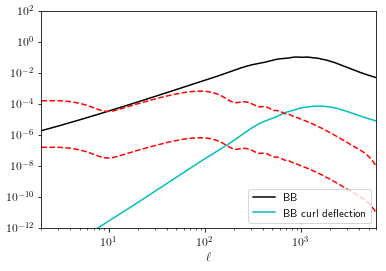

In [76]:
fac=lsamp*(lsamp+1)/2/np.pi

plt.loglog(Ref_ls,RefCB,color='k')
plt.loglog(Bcurl_L,Bcurl, color='c')

plt.loglog(np.arange(BB_tensor.size), BB_tensor,color='r',ls='--')
plt.loglog(np.arange(BB_tensor.size), BB_tensor*1e-3,color='r',ls='--') #r = 1e-5

plt.xlim([10,lsamp[-1]])
spcurl = UnivariateSpline(Bcurl_L, (2*Bcurl_L+1)/4/np.pi*Bcurl/Bcurl_L/(Bcurl_L+1)*2*np.pi, s=0)
var_B_curl =  spcurl.integral(Bcurl_L[0],Bcurl_L[-1])
print 'B curl variance, rms =', var_B_curl, np.sqrt(var_B_curl)
print 'Large-scale B curl power = A (l/%s)^2 with A='%100, spcurl(100)*4*np.pi/(2*100+1)

plt.legend(['BB','BB curl deflection'], loc='lower right')
plt.xlim([2, 6000]);
plt.ylim([1e-12,1e2]);
plt.xlabel(r'$\ell$');

In [20]:
##Polarization Rotation 
setPlotStyle(True)

In [21]:
def l2cl_general(chi_source, chi_ix=0,lens_ix=0, l_pow=2, chi_chi_ix=None):
    chi_source = np.float64(chi_source)
    if chi_chi_ix is None: chi_chi_ix = chi_source
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    win = 1/chis**4*(1-chis/chi_source)**lens_ix*(chis/chi_chi_ix)**chi_ix
    cl=np.zeros(ls.shape)
    w = np.ones(chis.shape)
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        cl[i] = np.dot(dchis,
            w*PK.P(zs, k, grid=False)*win/k**4)
    cl*= ls**l_pow
    return cl


#get grid of C_L(chi_s,k) for different redshifts
def l2cl_interpgrid(chi_ix=0,lens_ix=0, l_pow=2, plot=False, chi_chi_ix=None):
    nchimax = 100*acc
    chimaxs=np.linspace(0 ,chistar, nchimax)
    cls = np.zeros((nchimax,ls.size))
    for i, chimax in enumerate(chimaxs[1:]):
        cl = l2cl_general(chimax, chi_ix, lens_ix, l_pow, chi_chi_ix)
        cls[i+1,:] = cl
        if plot: plt.semilogx(ls,cl)
    cls[0,:]=0
    cl_deflect1_chi = RectBivariateSpline(chimaxs,ls,cls)
    return cl_deflect1_chi

#Get Mdeflect(l,l') matrix
def Mdeflect_quadrot():
    chis = np.linspace(0,chistar, nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    win = 1/chis**4
    win3 = win*(1-chis/chistar)**2
    win2= win*(1-chis/chistar)*2
    winx= win3
    winx2= win*(1-chis/chistar)
  
    cl=np.zeros(ls.shape)
    w = np.ones(chis.shape)
    interpgrid=l2cl_interpgrid(chi_ix=2, chi_chi_ix=chistar)
    interpgrid2=l2cl_interpgrid(chi_ix=1, chi_chi_ix=chistar)
    interpgrid3=l2cl_interpgrid(chi_ix=0)
    cchi = interpgrid(chis,ls, grid=True)
    cchi2 = interpgrid2(chis,ls, grid=True)
    cchi3 = interpgrid3(chis,ls, grid=True)

    interpgridx=l2cl_interpgrid(chi_ix=0, lens_ix=1, l_pow=3, chi_chi_ix=chistar)
    interpgridx2=l2cl_interpgrid(chi_ix=1, lens_ix=1, l_pow=3, chi_chi_ix=chistar)
    cchix = interpgridx(chis,ls, grid=True)
    cchix2 = interpgridx2(chis,ls, grid=True)
    
    Mdeflect = np.zeros((ls.size,ls.size))
    Mdeflectx = np.zeros((ls.size,ls.size))
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        base = dchis*w*PK.P(zs, k, grid=False)/k**4
        cl = np.dot(base*win,cchi) + np.dot(base*win2,cchi2) + np.dot(win3*base,cchi3)
        Mdeflect[i,:] = cl*l**2 
        
        cl = np.dot(base*winx,cchix)+ np.dot(base*winx2,cchix2) 
        Mdeflectx[i,:] = cl*l**3 


    Mdeflectsp = RectBivariateSpline(ls,ls,Mdeflect)
    Mdeflectspx = RectBivariateSpline(ls,ls,Mdeflectx)

    return Mdeflectsp, Mdeflectspx

def get_clquadrot():
    clquadrot = np.zeros(lsamp.shape)
    clquadrotx = np.zeros(lsamp.shape)
    Mdeflectsp,Mdeflectspx = Mdeflect_quadrot()

    for i, ll in enumerate(lsamp):

        l = np.float64(ll)
        l2=l**2
        lmin = lsall[0]
        lpmax=min(lmax,int(max(1000,l*2)))
        if ll<500:
           lcalc= lsall[0:lpmax-2]
        else:
            #sampling in l', with denser around l~l'
           lcalc = np.hstack((lsall[0:20:4],
                              lsall[29:ll-200:35],
                              lsall[ll-190:ll+210:6],
                              lsall[ll+220:lpmax+60:60] ))

        tmps = np.zeros(lcalc.shape) 
        tmpxs = np.zeros(lcalc.shape) 
        for ix,lp in enumerate(lcalc):
              llp=int(lp) 
              lp = np.float64(lp)
              if abs(ll-llp)>200 and lp>200:
                  nphi = 2*int(min(lp/10*acc,200))+1
              elif ll>2000:
                  nphi = 2*int(lp/10*acc)+1
              else:
                  nphi = 2*int(lp)+1
              dphi= 2*np.pi/nphi
              phi = np.linspace(dphi, (nphi-1)/2*dphi,  (nphi-1)//2) #even and don't need zero
              w = 2*np.ones(phi.size)
              cosphi = np.cos(phi)
              lrat = lp/l
              lfact = np.sqrt(1+lrat**2- 2*cosphi*lrat) 
              lnorm = l*lfact
              lfact[lfact<=0] = 1
              w[lnorm < lmin]=0
              w[lnorm > lmax]=0

              lnorm = np.maximum(lmin, np.minimum(lmax,lnorm))
              tmps[ix]+= lp*np.dot(w,(np.sin(phi)**2/lfact**2*
                        Mdeflectsp(lnorm,lp, grid=False)))*dphi
              tmpxs[ix]+= lp*np.dot(w,(np.sin(phi)**2/lfact**3*(cosphi-lrat)*
                    Mdeflectspx(lnorm,lp, grid=False)))*dphi

        sp = UnivariateSpline(lcalc, tmps, s=0)
        clquadrot[i] = sp.integral(2, lpmax-1)*4/(2*np.pi)**2
        sp = UnivariateSpline(lcalc, tmpxs, s=0)
        clquadrotx[i] = sp.integral(2, lpmax-1)*4/(2*np.pi)**2
        
    return clquadrot, clquadrotx


In [22]:
clquadrot, clquadrotx = get_clquadrot()

RMS rot: 3.02137084319e-07


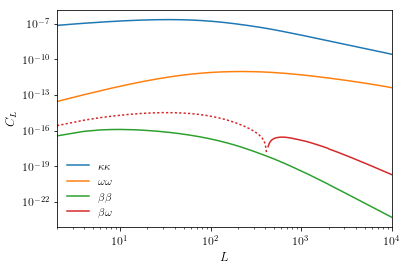

In [23]:
plt.loglog(ls,clkappa, color='C0')
plt.loglog(lsamp,clcurl, color='C1')
#plt.loglog(lsamp,clrot, color='C2')
plt.loglog(lsamp,clquadrot, color='C2')

#plt.loglog(lsamp,clrotcross, color='C3')
plt.loglog(lsamp,clquadrotx, color='C3')

#plt.loglog(lsamp,-clrotcross, color='C3',ls=':')
plt.loglog(lsamp,-clquadrotx, color='C3',ls=':')

plt.xlabel('$L$')
plt.ylabel('$C_L$')
plt.legend([r'$\kappa\kappa$',r'$\omega\omega$',r'$\beta\beta$',r'$\beta\omega$'], loc='lower left',frameon=False)
plt.xlim([2,1e4])
plt.savefig('pol_rotation_quad_CL.pdf', bbox_inches='tight')
sp = UnivariateSpline(lsamp, (2*lsamp+1)/4/np.pi*clquadrot, s=0)
var_rot =  sp.integral(lsamp[0],lsamp[-1])
print 'RMS rot:', np.sqrt(var_rot)

In [24]:
CurlSp = UnivariateSpline(lsamp,clcurl, s=0)
rotSp = UnivariateSpline(lsamp,clquadrot, s=0)
rotcrossSp = UnivariateSpline(lsamp,clquadrotx, s=0)
phiSp = UnivariateSpline(cl_ls,CPhi, s=0)

Bphi = np.zeros(lsamp.shape)
Brot = np.zeros(lsamp.shape)
Brotx = np.zeros(lsamp.shape)

for i, ll in enumerate(lsamp):
    if ll > cl_ls[-1]//2: break
    l = np.float64(ll)
    for llp in range(10,cl_ls[-1]):
      lp = np.float64(llp)
      if abs(ll-llp)>200 and lp>200:
          nphi = 2*int(min(lp/10*acc,200))+1
      elif ll>2000:
          nphi = 2*int(lp/10*acc)+1
      else:
          nphi = 2*int(lp)+1
      dphi= 2*np.pi/nphi
      phi = np.linspace(dphi, (nphi-1)/2*dphi,  (nphi-1)//2)
      w = 2*np.ones(phi.size)
      cosphi = np.cos(phi)
      sinphi = np.sin(phi)
      sin2phi = np.sin(2*phi)
      cos2phi = np.cos(2*phi)
      lpp = np.sqrt(lp**2+l**2- 2*cosphi*l*lp)
      w[lpp < 2]=0
      w[lpp > cl_ls[-1]]=0

      curls = CurlSp(lpp)
      dCEs = CEsp(lp)*lp*dphi
      crossterm = sinphi*l*lp/lpp**2
      Bphi[i]+= np.dot(w, phiSp(lpp)/lpp**4*(lp**2-lp*l*cosphi)**2*sin2phi**2) *dCEs

      Brot[i]+= np.dot(w, rotSp(lpp)*cos2phi**2) *dCEs
      Brotx[i]+= 2*np.dot(w, rotcrossSp(lpp)*sin2phi*cos2phi*crossterm) *dCEs


    Bphi[i]*= 4/(2*np.pi)**2
    Brot[i]*= 4/(2*np.pi)**2
    Brotx[i]*=-4/(2*np.pi)**2


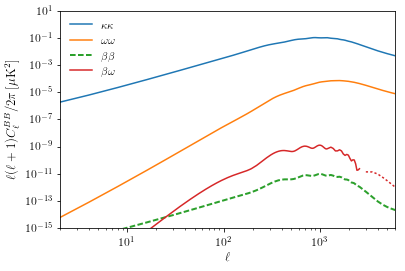

In [25]:
plt.figure(figsize=(6,4))
fac=lsamp*(lsamp+1)/2/np.pi
plt.loglog(lsamp,fac*Bphi,ls='-',color='C0')

plt.loglog(lsamp,Bcurl, color='C1')

plt.loglog(lsamp, fac*Brot,ls='--', color='C2', lw=2) 

plt.loglog(lsamp, fac*(Brotx),ls='-', color='C3') 
#plt.loglog(lsamp, fac*(Brot+Brotx+Bcurl2),ls='-', color='C4') 

plt.loglog(lsamp, -fac*(Brotx),ls=':', color='C3') 

plt.xlim([10,lsamp[-1]])
plt.legend([r'$\kappa\kappa$',r'$\omega\omega$',r'$\beta\beta$',r'$\beta\omega$'], loc='upper left', frameon=False)
plt.xlim([2, 6000]);
plt.ylim([1e-15,1e1]);
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1) C^{BB}_\ell%s$'%normtex)
plt.savefig('BB_pol_rotation_quad_CL.pdf', bbox_inches='tight')

In [26]:
##Power spectrum of difference potential
def cl_psi_d(chi_source):
    chi_source = np.float64(chi_source)
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    win = 1/chis**2/chi_source**2
    cl=np.zeros(ls.shape)
    w = np.ones(chis.shape)
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        cl[i] = np.dot(dchis,
            w*PK.P(zs, k, grid=False)*win/k**4)
    cl*= ls*(ls+1)
    return cl

#cross with lensing
def cl_psi_d_x_lens(chi_source):
    chi_source = np.float64(chi_source)
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    win = -(1-chis/chi_source)/chis**3/chi_source
    cl=np.zeros(ls.shape)
    w = np.ones(chis.shape)
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        cl[i] = np.dot(dchis,
            w*PK.P(zs, k, grid=False)*win/k**4)
    cl*= ls*(ls+1)
    return cl

(1e-10, 1e-06)

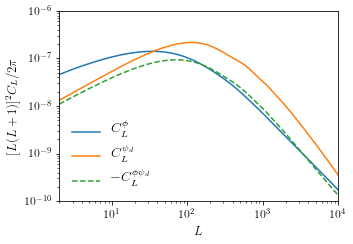

In [27]:
fig=plt.figure(figsize=(5,3.5))
clk = cl_kappa(chistar)

cld = cl_psi_d(chistar)
cldk = cl_psi_d_x_lens(chistar)
l2=ls*(ls+1)

plt.loglog(ls,4*clk/2/np.pi,color='C0')

plt.loglog(ls,4*l2*cld/2/np.pi,color='C1',ls='-')

plt.loglog(ls,-4*l2*cldk/2/np.pi,color='C2',ls='--')

plt.xlim([2,1e4])
plt.ylabel(r'$[L(L+1)]^2 C_L/2\pi$')
plt.xlabel('$L$')

plt.legend([r'$C_L^{\phi}$', r'$C_L^{\psi_d}$',r'$-C_L^{\phi\psi_d}$'], 
           loc='lower left',ncol=1, frameon=False, fontsize=14)

plt.ylim([1e-10,1e-6])
#plt.savefig('emission_angle_CL.pdf', bbox_inches='tight',fontsize=14)

In [28]:
##Emission angle changes to CMB

#first temperature and analytic delta visibility

def get_vel_power(params,k_per_logint, zstar=zmax):
    pars = copy.deepcopy(params)
    pars.set_matter_power(redshifts=[zstar], kmax=kmax, k_per_logint=k_per_logint, silent=True)
    pars.NonLinear = model.NonLinear_none
    pars.set_accuracy(AccuracyBoost=2)
    results = camb.get_results(pars)

    kh, z, pk = results.get_linear_matter_power_spectrum(model.Transfer_Newt_vel_baryon, 
                                                         model.Transfer_Newt_vel_baryon, False, 
                                                         nonlinear=0)
    kh *= pars.H0 / 100
    #h_of_z is non-comoving; model.Transfer_Newt_vel_baryon = -kv/H with H comoving
    return pk[0,:]*results.h_of_z(zmax)**2/(1+zmax)**2/kh**2, z, kh

Pvel, zvel, kvel = get_vel_power(pars,50)
print kvel.shape

(596L,)


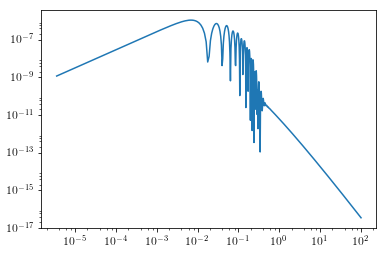

In [29]:
plt.loglog(kvel,kvel**2*Pvel)

In [30]:
Pvelstar=Pvel*kvel**3/2/np.pi**2
Pvelsp = UnivariateSpline(kvel, Pvelstar, s=0)

(596L,)


(0.0001, 0.2)

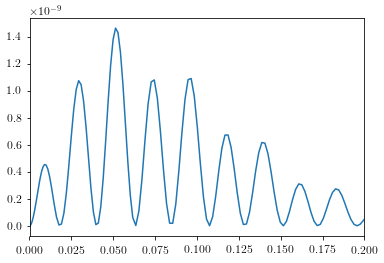

In [31]:
print Pvelstar.shape
plt.plot(kvel,Pvelstar)
plt.xlim([0.0001,0.2])


In [32]:
lsampvel = np.hstack((np.arange(2, 20, 2), np.arange(25, 200, 10//acc), np.arange(220, 1500, 30//acc),
                   np.arange(1530, min(lmax//2,4200), 50//acc),np.arange(4300, lmax//2+1, 300//acc)))

def vel_potential_cl(kmx=1.0, kspace=1e-4):
    CL = np.zeros(lsampvel.shape) 
    ks = np.arange(1e-5,kmx,kspace)
    for i, ll in enumerate(lsampvel):
        CL[i]=4*np.pi*kspace*np.sum(Pvelsp(ks)/ks**3/chistar**2*scipy.special.spherical_jn(ll,ks*chistar)**2)
    return CL
    

In [33]:
vel_deltavis_cl = vel_potential_cl(2)
vel_deltavis_cl_sp =UnivariateSpline(lsampvel, lsampvel**2*vel_deltavis_cl, s=0)

In [34]:
#Sources from CAMB sources modification. Note TE, Tzeta sign convention follows CAMB (opposite to paper)

#  if (tau<1000) then
#     sources(4) =  -(sigma+vb)*vis(j)/(k*(CP%tau0-tau)) !perp velocity at recombination
#    else
#     sources(4)=0
#    end if
    
#    if (x > 0._dl .and. tau<CP%ReionHist%tau_start) then
#        !1/4 times E polarization source
#        !We are sticking with CAMB's polarization convention here, so C_T_zeta is minus the one in the paper
#        chisource= (CP%tau0-tau)
#        sources(5)= (15._dl/8._dl) * (dvis(j)*polter + vis(j)*polterdot)/k**2/chisource !psi_zeta
#        sources(6)= (15._dl/8._dl) * (dvis(j)*polter + vis(j)*polterdot)/divfac*(CP%tau0-tau_maxvis) !psi_t
#        sources(7)= vis(j)*polter*(15._dl/8._dl)/divfac ! E without reionization
#        sources(8) = (15._dl/8._dl) * (vis(j)*polter/k**2/chisource**2 + &
#            vis(j)*polter/k**2/chisource + vis(j)*polterdot/k**2/chisource  ) !The other possible source (not used) 
#    else
#        sources(5)=0
#        sources(6)=0
#        sources(7)=0
#        sources(8)=0
#    end if
#    if (x>0 .and. tau > CP%ReionHist%tau_start) then   
#        chisource= (CP%tau0-tau)
#        sources(9)= (15._dl/8._dl) * (dvis(j)*polter + vis(j)*polterdot)/k**2/chisource !psi_zeta_reion
#        sources(10)=vis(j)*polter*(15._dl/8._dl)/k**2/chisource**2 !E reion
#    else
#        sources(9)=0  
#       sources(10)=0
#    end if

#Numerical results from CAMB (emission_angle branch on repositoryhosting, based on devel branch Feb 17)
file_name = r'outputs/vel_power_paper_scalCovCls.dat'
with open(file_name) as f:
    header = f.readline().split()[1:]
velcl = np.loadtxt(file_name)

def readCovPower(name, pow=0, Epow=0):
    #loads L^2 C_L
    ix = header.index(name)
    dat = velcl[:,ix]*2*np.pi
    if name.split('x')[0] in ['T','E','B']: dat/=(2.7255e6)
    if name.split('x')[1] in ['T','E','B']: dat/=(2.7255e6)
    if pow:
        dat *= (velcl[:,0]*(velcl[:,0]+1))**(pow/2.)
    if Epow:
        dat*= (velcl[:,0]*(velcl[:,0]+1)*(velcl[:,0]+2)*(velcl[:,0]-1))**(Epow/2.)
    return UnivariateSpline(velcl[:,0], dat, s=0)
    
#W1 is dipole, W2 is zeta_recomb, W3 is pol time delay, W4 is psi_E_recomb, W5 is psi_perp (unused), 
#W6 is zeta_reion, W7 is psi_E_reion

CT_sp = readCovPower('TxT')
CE_sp = readCovPower('ExE')
velcl_sp = readCovPower('W1xW1')
velTcl_sp = readCovPower('TxW1')
polcl_sp = readCovPower('W2xW2')
#polEcl_sp = readCovPower('ExW2') #don't want reionization
polTcl_sp = readCovPower('TxW2')
polvcl_sp = readCovPower('W1xW2')

poldelaycl_sp = readCovPower('W3xW3')
poldelayEcl_sp = readCovPower('ExW3')
poldelayemissioncl_sp = readCovPower('W2xW3')

polEcl_sp = readCovPower('W2xW4', Epow=1)
EEnoreioncl_sp = readCovPower('W4xW4',Epow=2, pow=-2) #raw CEE  l^4*1/l^2

polreioncl_sp = readCovPower('W6xW6')
polreionEcl_sp = readCovPower('W6xW7', Epow=1)
EEreioncl_sp = readCovPower('W7xW7',Epow=2, pow= -2) #raw CEE  l^4*1/l^2

lmax_e = int(velcl[-1,0])
print lmax_e

6000


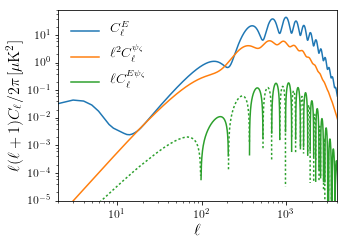

In [35]:
norm = 2.726**2*1e12/2/np.pi

fig=plt.figure(figsize=(5,3.5))
plt.loglog(velcl[:,0],CE_sp(velcl[:,0])*norm)
plt.loglog(velcl[:,0],velcl[:,0]**2*polcl_sp(velcl[:,0])*norm,color='C1')

plt.loglog(velcl[:,0],velcl[:,0]*polEcl_sp(velcl[:,0])*norm, color='C2')
plt.loglog(velcl[:,0],-velcl[:,0]*polEcl_sp(velcl[:,0])*norm, color='C2',ls=':')

if False:
    plt.loglog(velcl[:,0],velcl[:,0]*reionpolEcl_sp(velcl[:,0])*norm, color='C2', ls='--')
    plt.loglog(velcl[:,0],velcl[:,0]**2*reionpolcl_sp(velcl[:,0])*norm,color='C1', ls='--')
    plt.loglog(velcl[:,0],velcl[:,0]**2*EEreioncl_sp(velcl[:,0])*norm.pi,color='C0', ls='--')

plt.xlim([2,lmax_e])
plt.ylim([1e-5,80])
plt.legend(['$C_\ell^E$',r'$\ell^2 C_\ell^{\psi_\zeta}$',r'$\ell C_\ell^{E\psi_\zeta}$'],
           loc='upper left',fontsize=14, frameon=False)
plt.xlabel(r'$\ell$',fontsize=16)
plt.ylabel(r'$\ell(\ell+1) C_\ell%s$'%normtex,fontsize=16)
plt.xlim([2, 4000])
plt.savefig('pol_potential_CL.pdf', bbox_inches='tight')

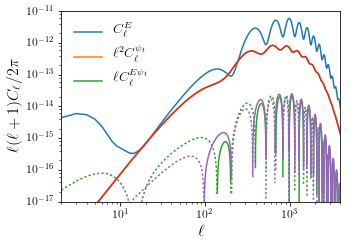

In [36]:
#Compare to time delay potential, which is similar
fig=plt.figure(figsize=(5,3.5))
plt.loglog(velcl[:,0],CE_sp(velcl[:,0])/2/np.pi)
plt.loglog(velcl[:,0],velcl[:,0]**2*poldelaycl_sp(velcl[:,0])/2/np.pi,color='C1')

plt.loglog(velcl[:,0],velcl[:,0]*poldelayEcl_sp(velcl[:,0])/2/np.pi, color='C2')
plt.loglog(velcl[:,0],-velcl[:,0]*poldelayEcl_sp(velcl[:,0])/2/np.pi, color='C2',ls=':')

plt.loglog(velcl[:,0],velcl[:,0]**2*polcl_sp(velcl[:,0])/2/np.pi,color='C3')
plt.loglog(velcl[:,0],velcl[:,0]*polEcl_sp(velcl[:,0])/2/np.pi, color='C4')
plt.loglog(velcl[:,0],-velcl[:,0]*polEcl_sp(velcl[:,0])/2/np.pi, color='C4', ls=':')

plt.xlim([2,lmax_e])
plt.ylim([1e-17,1e-11])
plt.legend(['$C_\ell^E$',r'$\ell^2 C_\ell^{\psi_t}$',r'$\ell C_\ell^{E\psi_t}$'],
           loc='upper left',fontsize=14, frameon=False)
plt.xlabel(r'$\ell$',fontsize=16)
plt.ylabel(r'$\ell(\ell+1) C_\ell/2\pi$',fontsize=16)
plt.xlim([2, 4000]);

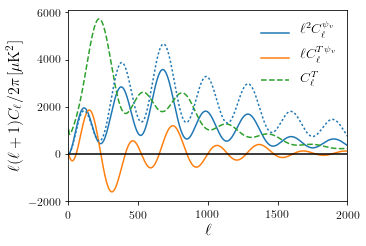

In [37]:
fig=plt.figure(figsize=(5,3.5))
lsampvel=velcl[:,0]
plt.plot(lsampvel,lsampvel**2*velcl_sp(lsampvel)*norm,color='C0')
plt.plot(lsampvel,lsampvel*velTcl_sp(lsampvel)*norm,color='C1')
plt.plot(lsampvel,CT_sp(lsampvel)*norm,color='C2',ls='--')
plt.plot(lsampvel,np.exp(-2*0.0581)*lsampvel**2*vel_deltavis_cl_sp(lsampvel)*norm,ls=':',color='C0')
plt.axhline(0,color='k')
plt.xlim([0,2000])
#plt.ylim([-3e-10,8e-10])
plt.xlabel(r'$\ell$',fontsize=16)
plt.ylabel(r'$\ell(\ell+1) C_\ell%s$'%normtex,fontsize=16)
plt.legend([r'$\ell^2 C^{\psi_v}_\ell$',r'$\ell C^{T\psi_v}_\ell$',r'$C^{T}_\ell$'],fontsize=14, frameon=False)
plt.savefig('velocity_potential_CL.pdf', bbox_inches='tight')

In [38]:
#Relevant lensing/emission power spectra

cl_kappa_sp = UnivariateSpline(ls,4*cl_kappa(chistar),s=0)
cl_phi_sp = UnivariateSpline(ls,4*cl_kappa(chistar)/(ls*(ls+1)),s=0)

cl_psi_d_sp = UnivariateSpline(ls,4*cl_psi_d(chistar),s=0)
cl_psi_d_x_lens_sp = UnivariateSpline(ls,4*cl_psi_d_x_lens(chistar),s=0)

chi_reion = results.comoving_radial_distance(8.1)
reion_cl_kappa_sp = UnivariateSpline(ls,4*cl_kappa(chi_reion),s=0)
reion_cl_phi_sp = UnivariateSpline(ls,4*cl_kappa(chi_reion)/(ls*(ls+1)),s=0)

reion_cl_psi_d_sp = UnivariateSpline(ls,4*cl_psi_d(chi_reion),s=0)
reion_cl_psi_d_x_lens_sp = UnivariateSpline(ls,4*cl_psi_d_x_lens(chi_reion),s=0)

lsum = np.arange(2,ls[-1])
varcrossterm= np.sum(cl_psi_d_x_lens_sp(lsum)*lsum)/2/np.pi
varcrosstermd= np.sum(cl_psi_d_sp(lsum)*lsum)/2/np.pi
print varcrossterm,varcrosstermd

-3.03457347896e-07 6.59522557728e-07


In [39]:
#variance from summing CL, to be compared with earlier var_xx results from Pk directly
def get_rms(cl, arcmin=True, fac=0):
    sumL=np.arange(2,lmax//2, dtype=np.float64)
    intcls = cl(sumL)
    if fac: intcls *= (sumL*(sumL+1))**(fac/2.)
    var = np.dot(intcls,(2*sumL+1))/4/np.pi
    res=np.sqrt(var)
    if arcmin: res*= 180*60/np.pi
    return res

print 'RMS alpha:', get_rms(cl_phi_sp)
print 'RMS d:', get_rms(cl_psi_d_sp)
print 'RMS psi_d:', get_rms(cl_psi_d_sp, fac=-2, arcmin=False)
print 'RMS delta_chi/Mpc:', get_rms(cl_psi_d_sp, fac=-2, arcmin=False)*chistar


RMS alpha: 2.461860451
RMS d: 2.81188352541
RMS psi_d: 5.08618226374e-05
RMS delta_chi/Mpc: 0.705630724673


In [40]:
lsampvelcl = np.hstack((np.arange(2, 20, 2), np.arange(25, 200, 20//acc), np.arange(220, 1200, 40//acc),
                   np.arange(1240, min(lmax//2,lmax_e), 50//acc)))

In [41]:
#convolution theorem way to evaluate the integrals as an alternative and cross-check

def cl2corr(func, xvals, lmax = lmax_e, order=0, interp_argmax = 100, interp = True, lpow=0):
    xvals = np.asarray(xvals)
    ls = np.arange(2, lmax+1, dtype=np.float64)
    corrs = np.zeros(len(xvals))
    ct = ls*func(ls)/(2*np.pi)*ls**lpow    
    if interp:
        intvals = np.linspace(0,interp_argmax, 4000)
        jsp = UnivariateSpline(intvals,scipy.special.jn(order,intvals),s=0)
    for i, x in enumerate(xvals):
         arg = x*ls
         if interp:
             J = jsp(arg) 
             J[arg > interp_argmax] = 0 
         else:
            J = scipy.special.jn(order, arg) 
         corrs[i] = np.dot(ct, J)  
    return corrs

def Convolve2D(func, func2, pifrac=32, pows=[0,2], pows2=None,weights=[0.5,0.5], backpow=0,nx=0.6*lmax_e,
               lsampvelcl=lsampvelcl, prefactor=1, spline=True, lpows=None, lpows2=None):
    ##cos(pow psi)*func*func2
    #defaults are for int d^L/(2pi)^2 {[L\cdot(l1-L)]^2/(L^2(l1-L)^2)} func(L)func(l1-L)
    xvals=np.linspace(0,np.pi/pifrac,nx)
    xdx = xvals*np.concatenate((([(xvals[1]-xvals[0])/2],(xvals[2:]-xvals[:-2])/2,[(xvals[-1]-xvals[-2])/2])))
    integrand=None
    if pows2 is None: pows2=pows
    if lpows is None: lpows = [0]*len(weights)
    if lpows2 is None: lpows2 = [0]*len(weights)        
    for pow,pow2, lpow, lpow2, weight in zip(pows,pows2,lpows, lpows2,weights):
        corrs = cl2corr(func, xvals, order=pow, lpow=lpow)
        corrs2 = cl2corr(func2, xvals, order=pow2, lpow=lpow2)
        if integrand is None:
            integrand = weight*corrs*corrs2
        else:
            integrand += weight*corrs*corrs2
    result = np.zeros(lsampvelcl.size)
    integrand *= xdx
    for i, ll in enumerate(lsampvelcl):
        result[i]=np.dot(integrand,scipy.special.jn(backpow, xvals*ll))  
    result*= 2*np.pi*prefactor
    if spline:
        return UnivariateSpline(lsampvelcl ,result,s=0)
    else:
        return result


In [42]:
#Direct way to get velocity terms

cldeltavel = np.zeros(lsampvelcl.shape)
cldeltavelx = np.zeros(lsampvelcl.shape)

lstep = 5
for i, ll in enumerate(lsampvelcl):
    l = np.float64(ll)
    for llp in range(2,lmax_e, lstep):
      lp = np.float64(llp)
      if abs(ll-llp)>200 and lp>200:
          nphi = 2*int(min(lp/10*acc,200))+1
      elif ll>4000:
          nphi = 2*int(lp/10*acc)+1
      else:
          nphi = 2*int(lp)+1
      dphi= 2*np.pi/nphi
      if True:
          phi = np.linspace(0, (nphi-1)/2*dphi, (nphi-1)//2+1)
          w = np.ones(phi.size)
          w[1:]=2
      else:
          phi = np.linspace(dphi, (nphi-1)/2*dphi,  (nphi-1)//2)
          w = 2*np.ones(phi.size)
      cosphi = np.cos(phi)
      lpp = np.sqrt(lp**2+l**2- 2*cosphi*l*lp)
      w[lpp < 2]=0
      w[lpp >lmax_e]=0
      lpp[lpp==0]=1

      cldeltavel[i]+= lp*np.dot(w,((cosphi-lp/l)*(l/lpp))**2*velcl_sp(lpp))*dphi*cl_psi_d_sp(lp)
      cldeltavelx[i]+= lp*np.dot(w,((cosphi-lp/l)*(l/lpp))**2*velTcl_sp(lpp))*dphi*cl_psi_d_x_lens_sp(lp)
        
cldeltavel*=lstep/(2*np.pi)**2
cldeltavelx*=2*lstep/(2*np.pi)**2
cldeltavelsp = UnivariateSpline(lsampvelcl ,cldeltavel,s=0)
cldeltavelxsp = UnivariateSpline(lsampvelcl ,cldeltavelx,s=0)

In [43]:
cldeltavelx_checksp=Convolve2D(cl_psi_d_x_lens_sp,velTcl_sp, prefactor=2)


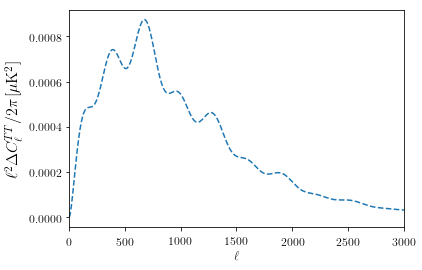

In [44]:
lvecplot = np.arange(2,lmax_e)
plt.plot(lvecplot ,lvecplot**2*cldeltavelsp(lvecplot)*2.726**2*1e12/2/np.pi,'--')
lmax_e_plot =3000
plt.xlim([2,lmax_e_plot])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2 \Delta C_{\ell}^{TT}%s$'%normtex,fontsize=16)
plt.savefig('velocity_delta_CL_TT_auto.pdf', bbox_inches='tight',fontsize=16)

(2, 3000)

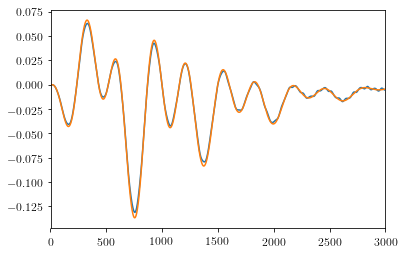

In [45]:
#check cross convolution
lvecplot = np.arange(2,lmax_e)
fac = lvecplot**2*norm
plt.plot(lvecplot ,fac*cldeltavelx_checksp(lvecplot))
plt.plot(lvecplot ,fac*cldeltavelxsp(lvecplot))
plt.xlim([2,3000])


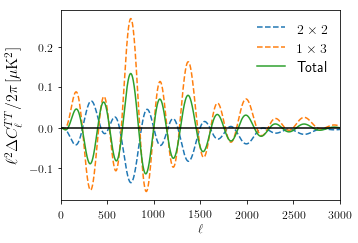

In [46]:
fig=plt.figure(figsize=(5,3.5))
plt.plot(lvecplot ,fac*cldeltavelxsp(lvecplot),ls='--')

plt.plot(lvecplot,-varcrossterm* velTcl_sp(lvecplot)*fac,ls='--')
plt.plot(lvecplot,(-varcrossterm* velTcl_sp(lvecplot)+
                   cldeltavelxsp(lvecplot))*fac)

plt.axhline(0,color='k')
plt.xlim([2,lmax_e_plot])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2 \Delta C_{\ell}^{TT}%s$'%normtex,fontsize=16)
plt.legend([r'$2 \times 2$',r'$1 \times 3$','Total'],loc='upper right', frameon=False,fontsize=14)
plt.savefig('velocity_delta_CL_TT_cross.pdf', bbox_inches='tight')

In [47]:
#E/B power from Emission only
cldeltaB = np.zeros(lsampvelcl.shape)
cldeltaBx = np.zeros(lsampvelcl.shape)
cldeltaE = np.zeros(lsampvelcl.shape)
cldeltaEx = np.zeros(lsampvelcl.shape)
lstep = 5
for i, ll in enumerate(lsampvelcl):
    if ll > cl_ls[-1]//2: break
    l = np.float64(ll)
    for llp in range(2,lmax_e, lstep):
      lp = np.float64(llp)
      if abs(ll-llp)>200 and lp>200:
          nphi = 2*int(min(lp/10*acc,200))+1
      elif ll>4000:
          nphi = 2*int(lp/10*acc)+1
      else:
          nphi = 2*int(lp)+1
      dphi= 2*np.pi/nphi
      #phi = np.linspace(dphi, (nphi-1)/2*dphi,  (nphi-1)//2)
      #w = 2*np.ones(phi.size)
      phi = np.linspace(0, (nphi-1)/2*dphi, (nphi-1)//2+1)
      w = np.ones(phi.size)
      w[1:]=2
      cosphi = np.cos(phi)
      cos2phi = np.cos(2*phi)
      sinphi = np.sin(phi)
      sin2phi = np.sin(2*phi)

      lpp = np.sqrt(lp**2+l**2- 2*cosphi*l*lp)
      w[lpp < 2]=0
      w[lpp > lmax_e]=0
      lpp[lpp==0]=1
      cldeltaE[i]+= lp*np.dot(w,(cosphi*l - lp*cos2phi)**2*cl_psi_d_sp(lpp)/lpp**2)*dphi*polcl_sp(lp)
      cldeltaB[i]+= lp*np.dot(w,(sinphi*l - lp*sin2phi)**2*cl_psi_d_sp(lpp)/lpp**2)*dphi*polcl_sp(lp)

      cldeltaEx[i]+= lp*np.dot(w,(cosphi*l - lp*cos2phi)*(l*cosphi-lp)*
                                 cos2phi*cl_psi_d_x_lens_sp(lpp)/lpp**2)*dphi*polEcl_sp(lp)
      cldeltaBx[i]+= lp*np.dot(w,(sinphi*l - lp*sin2phi)*(l*cosphi-lp)*
                                 sin2phi*cl_psi_d_x_lens_sp(lpp)/lpp**2)*dphi*polEcl_sp(lp)
        
cldeltaE*=4*lstep/(2*np.pi)**2
cldeltaB*=4*lstep/(2*np.pi)**2
cldeltaEx*=-4*lstep/(2*np.pi)**2
cldeltaBx*=-4*lstep/(2*np.pi)**2


cldeltaEsp = UnivariateSpline(lsampvelcl ,cldeltaE,s=0)
cldeltaExsp = UnivariateSpline(lsampvelcl ,cldeltaEx,s=0)
cldeltaBsp = UnivariateSpline(lsampvelcl ,cldeltaB,s=0)
cldeltaBxsp = UnivariateSpline(lsampvelcl ,cldeltaBx,s=0)

In [48]:
intls = np.arange(2,lmax_e)
whiteBBauto = 4*np.dot(intls,polcl_sp(intls)*cl_psi_d_sp(intls))/4/np.pi
whiteBBcross = 4*np.dot(intls, - cl_psi_d_x_lens_sp(intls)*polEcl_sp(intls))/4/np.pi
whiteBB =whiteBBauto+whiteBBcross
#NoiseVar = (sensitivity * np.pi / 180 / 60.)**2
print 'Noise auto, noise, noise auto eff = ', whiteBBauto*2.726**2*1e12, \
         whiteBB*2.726**2*1e12, np.sqrt(whiteBBauto*2.726**2*1e12)*180*60/np.pi

Noise auto, noise, noise auto eff =  1.82199960885e-10 1.51002365531e-10 0.0464032097902


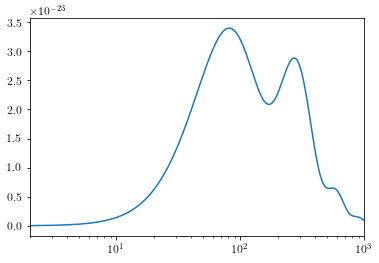

In [49]:
#Where are contributions from in L?
plt.semilogx(intls,intls**2*polcl_sp(intls)*cl_psi_d_sp(intls))
plt.xlim([2, 1000]);

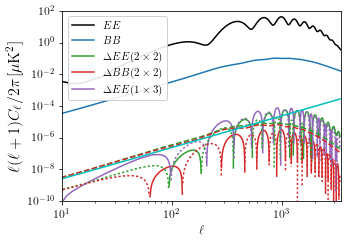

In [50]:
#compare terms

fig=plt.figure(figsize=(5,3.5))
lvecplot = np.arange(2,3401)
plt.loglog(Ref_ls,RefCE,color='k')
plt.loglog(Ref_ls,RefCB,color='C0')
fac=lvecplot*(lvecplot+1)*norm

plt.loglog(lvecplot, fac*cldeltaExsp(lvecplot),ls='-',color='C2')
plt.loglog(lvecplot, fac*cldeltaBxsp(lvecplot),ls='-',color='C3')

#1x3
plt.loglog(lvecplot, -varcrosstermd*CEsp(lvecplot)+2*varcrossterm*polEcl_sp(lvecplot)*fac,ls='-',color='C4')


plt.loglog(lvecplot,  varcrosstermd*CEsp(lvecplot)
                     -varcrossterm*polEcl_sp(lvecplot)*fac,ls=':',color='C4')


plt.loglog(lvecplot, cldeltaEsp(lvecplot)*fac,ls='--',color='C2')
plt.loglog(lvecplot, cldeltaBsp(lvecplot)*fac,ls='--',color='C3')

plt.loglog(lvecplot, -cldeltaExsp(lvecplot)*fac,ls=':',color='C2')
plt.loglog(lvecplot, -cldeltaBxsp(lvecplot)*fac,ls=':',color='C3')

plt.loglog(lvecplot, whiteBB*fac, color='c')

plt.xlim([10,3500])
plt.ylim([1e-10,100])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1) C_{\ell}%s$'%normtex,fontsize=16)
plt.legend([r'$EE$',r'$BB$',r'$\Delta EE (2 \times 2)$',r'$\Delta BB (2 \times 2)$', r'$\Delta EE (1 \times 3)$'],
           loc='upper left',framealpha=0.9)
plt.savefig('pol_delta_CL.pdf', bbox_inches='tight',fontsize=16)


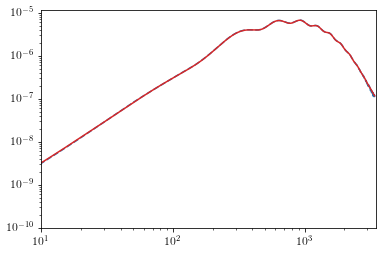

In [51]:
#Cross-check with correlation function method (just auto, cross term looks messier)
CPlus = Convolve2D(cl_psi_d_sp, polcl_sp,pows=[0], weights=[0.5], spline=False, prefactor=4)
CMinus = Convolve2D(cl_psi_d_sp, polcl_sp,pows=[2], weights=[0.5], backpow=4, spline=False, prefactor=4)
testautoEE=UnivariateSpline(lsampvelcl,CPlus+CMinus,s=0)
testautoBB=UnivariateSpline(lsampvelcl,CPlus-CMinus,s=0)

plt.loglog(lvecplot, testautoBB(lvecplot)*fac,ls='--',color='C0')
plt.loglog(lvecplot, cldeltaBsp(lvecplot)*fac,ls='-',color='C3')
plt.xlim([10,3500]);

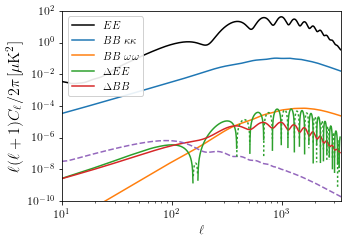

In [52]:
fig=plt.figure(figsize=(5,3.5))
lvecplot = np.arange(2,3401)
plt.loglog(Ref_ls ,RefCE,color='k')
plt.loglog(Ref_ls ,RefCB,color='C0')
fac=lsamp*(lsamp+1)/2/np.pi
plt.loglog(Bcurl_L,Bcurl, color='C1')
fac=lvecplot*(lvecplot+1)*norm

totE = 2*varcrossterm*polEcl_sp(lvecplot) + cldeltaExsp(lvecplot) + cldeltaEsp(lvecplot)  -varcrosstermd*CEsp(lvecplot)/fac
plt.loglog(lvecplot, totE*fac,ls='-',color='C2')

plt.loglog(lvecplot,(cldeltaBsp(lvecplot)+cldeltaBxsp(lvecplot))*fac,ls='-',color='C3')

plt.loglog(np.arange(BB_tensor.size), 1e-3*BB_tensor,color='C4',ls='--')

plt.loglog(lvecplot, -totE*fac,ls=':',color='C2')

#plt.loglog(lvecplot, whiteBB*fac, color='c')

plt.xlim([10,3500])
plt.ylim([1e-10,100])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1) C_{\ell}%s$'%normtex,fontsize=16)
plt.legend([r'$EE$',r'$BB$ $\kappa\kappa$',r'$BB$ $\omega\omega$',r'$\Delta EE$',r'$\Delta BB$'],
           loc='upper left', framealpha=0.9)
plt.savefig('pol_delta_total_CL.pdf', bbox_inches='tight',fontsize=16)

In [53]:
print 'BB(L=100) = ', (cldeltaBsp(100)+cldeltaBxsp(100))*2.726**2*1e12

BB(L=100) =  1.98594844748e-10


In [54]:
#Quadrupole source for temperature. Recall CAMB has opposite sign convention for Txpol
%time cldeltaT_polx2 = Convolve2D(cl_psi_d_x_lens_sp,polTcl_sp,nx=lmax_e/2, prefactor=-2)

Wall time: 3.39 s


In [55]:
cldeltaT_polv2 = Convolve2D(cl_psi_d_sp,polvcl_sp,nx=lmax_e/2, prefactor=-2)
cldeltaT_polzeta2  = Convolve2D(cl_psi_d_sp,polcl_sp,nx=lmax_e/2, prefactor=4)

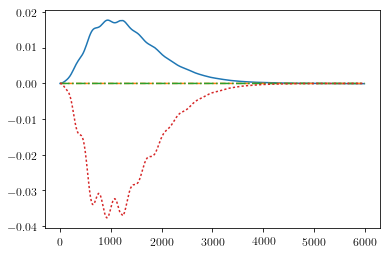

In [56]:
#lensing cross terms in quadrupole contribution to temperature compared to negligible others
onethree = 2*polTcl_sp(lsampvelcl)*varcrossterm

plt.plot(lsampvelcl,lsampvelcl**2*cldeltaT_polx2(lsampvelcl)*norm)
plt.plot(lsampvelcl,lsampvelcl**2*cldeltaT_polv2(lsampvelcl)*norm,'--')
plt.plot(lsampvelcl,lsampvelcl**2*cldeltaT_polzeta2(lsampvelcl)*norm,'-.')
plt.plot(lsampvelcl,lsampvelcl**2*onethree*norm,':');

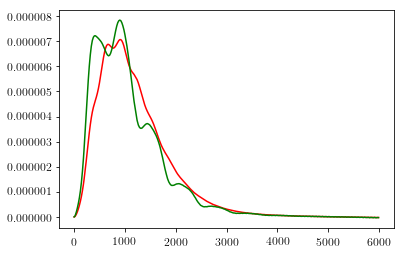

In [57]:
#other terms aer much smaller
plt.plot(lsampvelcl,lsampvelcl**2*(cldeltaT_polzeta2(lsampvelcl))*norm, color='r')
plt.plot(lsampvelcl,lsampvelcl**2*(cldeltaT_polv2(lsampvelcl))*norm, color='g');

In [58]:
#B power with time delay
totcldeltaB = np.zeros(lsampvelcl.shape)

totcldeltaBx = np.zeros(lsampvelcl.shape)
totcldeltaBEterm = np.zeros(lsampvelcl.shape)

lstep = 5
for i, ll in enumerate(lsampvelcl):
    if ll > cl_ls[-1]//2: break
    l = np.float64(ll)
    for llp in range(2,lmax_e, lstep):
      lp = np.float64(llp)
      if abs(ll-llp)>200 and lp>200:
          nphi = 2*int(min(lp/10*acc,200))+1
      elif ll>4000:
          nphi = 2*int(lp/10*acc)+1
      else:
          nphi = 2*int(lp)+1
      dphi= 2*np.pi/nphi
      phi = np.linspace(0, (nphi-1)/2*dphi, (nphi-1)//2+1)
      w = np.ones(phi.size)
      w[1:]=2
      cosphi = np.cos(phi)
      cos2phi = np.cos(2*phi)
      sinphi = np.sin(phi)
      sin2phi = np.sin(2*phi)

      lpp = np.sqrt(lp**2+l**2- 2*cosphi*l*lp)
      w[lpp < 2]=0
      w[lpp > lmax_e]=0
      lpp[lpp==0]=1
 
      totcldeltaB[i]+=lp*lp**2*np.dot(w,sin2phi**2 *polcl_sp(lpp) /lpp**2)*dphi*cl_psi_d_sp(lp)
      #this gives same result (changing variable)
      #totcldeltaB[i]+= 4*lp*np.dot(w,(sinphi*l - lp*sin2phi/2)**2*cl_psi_d_sp(lpp)/lpp**2)*dphi*polcl_sp(lp)
         
      totcldeltaBx[i]+= lp*np.dot(w,(sinphi*l - lp*sin2phi/2)*sin2phi*
                                  (cl_psi_d_x_lens_sp(lpp)*(l*cosphi-lp) + cl_psi_d_sp(lpp)/lp)/lpp**2 
                                  )*dphi*polEcl_sp(lp)
     
      totcldeltaBEterm[i]+= lp*np.dot(w,(sin2phi)**2*
                     (2*(l*cosphi-lp)*cl_psi_d_x_lens_sp(lpp) + cl_psi_d_sp(lpp)/lp)/lpp**2)*dphi*EEnoreioncl_sp(lp)*lp


totcldeltaB*=lstep/(2*np.pi)**2

totcldeltaBx*=-4*lstep/(2*np.pi)**2
totcldeltaBEterm*=lstep/(2*np.pi)**2

totcldeltaBsp = UnivariateSpline(lsampvelcl ,totcldeltaB,s=0)
totcldeltaBxsp = UnivariateSpline(lsampvelcl ,totcldeltaBx,s=0)
totcldeltaBEtermsp = UnivariateSpline(lsampvelcl ,totcldeltaBEterm,s=0)

In [59]:
reiontotcldeltaB = np.zeros(lsampvelcl.shape)
reiontotcldeltaBx = np.zeros(lsampvelcl.shape)
reiontotcldeltaBEterm = np.zeros(lsampvelcl.shape)
llpmax= lmax_e//3
lstep = 1
for i, ll in enumerate(lsampvelcl):
    if ll > cl_ls[-1]//2: break
    l = np.float64(ll)
    for llp in range(2,llpmax, lstep):
      lp = np.float64(llp)
      if abs(ll-llp)>200 and lp>200:
          nphi = 2*int(min(lp/10*acc,200))+1
      elif ll>4000:
          nphi = 2*int(lp/10*acc)+1
      else:
          nphi = 2*int(lp)+1
      dphi= 2*np.pi/nphi
      phi = np.linspace(0, (nphi-1)/2*dphi, (nphi-1)//2+1)
      w = np.ones(phi.size)
      w[1:]=2
      cosphi = np.cos(phi)
      cos2phi = np.cos(2*phi)
      sinphi = np.sin(phi)
      sin2phi = np.sin(2*phi)

      lpp = np.sqrt(lp**2+l**2- 2*cosphi*l*lp)
      w[lpp < 2]=0
      w[lpp > llpmax]=0
      lpp[lpp==0]=1
      reiontotcldeltaB[i]+= lp*np.dot(w,(sin2phi)**2*
                                      polreioncl_sp(lpp)/lpp**2)*dphi*reion_cl_psi_d_sp(lp)*lp**2
      #reiontotcldeltaB[i]+= 4*lp*np.dot(w,(sinphi*l - lp*sin2phi/2)**2*
      #                                reion_cl_psi_d_sp(lpp)/lpp**2)*dphi*polreioncl_sp(lp)
      
    
      reiontotcldeltaBx[i]+= lp*np.dot(w,(sinphi*l - lp*sin2phi/2)*sin2phi*
                                  (reion_cl_psi_d_x_lens_sp(lpp)*(l*cosphi-lp) + reion_cl_psi_d_sp(lpp)/lp)/lpp**2 
                                  )*dphi*polreionEcl_sp(lp)
     
      reiontotcldeltaBEterm[i]+= lp*np.dot(w,(sin2phi)**2*
                     (2*(l*cosphi-lp)*reion_cl_psi_d_x_lens_sp(lpp) 
                      + reion_cl_psi_d_sp(lpp)/lp)/lpp**2)*dphi*EEreioncl_sp(lp)*lp


reiontotcldeltaB*=lstep/(2*np.pi)**2
reiontotcldeltaBx*=-4*lstep/(2*np.pi)**2
reiontotcldeltaBEterm*=lstep/(2*np.pi)**2

reiontotcldeltaBsp = UnivariateSpline(lsampvelcl ,reiontotcldeltaB,s=0)
reiontotcldeltaBxsp = UnivariateSpline(lsampvelcl ,reiontotcldeltaBx,s=0)
reiontotcldeltaBEtermsp = UnivariateSpline(lsampvelcl ,reiontotcldeltaBEterm,s=0)

In [60]:
#Full sky reion formula as check
reionfullautoB = np.zeros(lsampvelcl.shape)
reionfullBEterm = np.zeros(lsampvelcl.shape)
reionfullBxterm= np.zeros(lsampvelcl.shape)
reionlensingB = np.zeros(lsampvelcl.shape)

lstep=1
lsarr=np.arange(2,lmax_e+1, dtype=np.float64)
llp1=(lsarr*(lsarr+1))
cdd = reion_cl_psi_d_sp(lsarr)*(lsarr+2)*(lsarr-1)*(2*lsarr+1)
cd = reion_cl_psi_d_sp(lsarr)/llp1*(2*lsarr+1)
cxdd = reion_cl_psi_d_x_lens_sp(lsarr)*(2*lsarr+1)
cxd = cxdd/llp1
cEE= EEreioncl_sp(lsarr)*(2*lsarr+1) #raw CL
cEx = polreionEcl_sp(lsarr)*(2*lsarr+1)
cExx = cEx/llp1
czeta = polreioncl_sp(lsarr)/llp1*(2*lsarr+1) 
cphi = reion_cl_phi_sp(lsarr)*(2*lsarr+1)/llp1
llpmax=lmax_e//2
for i, ll in enumerate(lsampvelcl):
    l = np.float64(ll)
    for llp in range(2,llpmax+1, lstep):
        lp = np.float64(llp)
        wig = threej(llp,ll,2,-2)
        minl=np.abs(llp-ll)
        if minl<2:
            wig = wig[2-minl:]
        wigx = threej(llp,ll,0,-2)
        minl = max(2,np.abs(llp-ll))
        maxl= min(llpmax,np.abs(llp+ll))
        off=0
        if (minl+llp+ll)%2==0: off=1
        wig2=wig[off:maxl-minl+1:2]**2
        if not len(wig2) or maxl<minl: continue
        reionfullautoB[i]+= np.dot(wig2,czeta[minl+off-2:maxl+1-2:2])*cdd[llp-2]
        reionfullBEterm[i]+= np.dot(wig2,cd[minl+off-2:maxl+1-2:2]
                      - cxdd[minl+off-2:maxl+1-2:2]
                      - (lp*(lp+1)-ll*(ll+1))*cxd[minl+off-2:maxl+1-2:2] )*cEE[llp-2]
        wigx2 = wigx[off:maxl-minl+1:2]*wig[off:maxl-minl+1:2]
        reionfullBxterm[i] += (np.dot(wigx2,
                               cExx[minl+off-2:maxl+1-2:2])*(2* cd[llp-2]
                                - ((lp*(lp+1)-ll*(ll+1))*cxd[llp-2])) 
                         -np.dot(wigx2,cEx[minl+off-2:maxl+1-2:2] )*cxd[llp-2] )*np.sqrt(
                                        lp*(lp+1)*(lp+2)*(lp-1))
        lsum= np.arange(minl+off,maxl+1,2)
        reionlensingB[i]+= np.dot(wig2, (lsum*(lsum+1) + lp*(lp+1)-ll*(ll+1))**2*cphi[minl+off-2:maxl+1-2:2]
                                 )*cEE[llp-2]/4 
        

reionfullautoB*=lstep/(4*np.pi)
reionfullautoBsp = UnivariateSpline(lsampvelcl ,reionfullautoB,s=0)
reionfullBEterm*=lstep/(4*np.pi)
reionfullBEtermsp = UnivariateSpline(lsampvelcl ,reionfullBEterm,s=0)
reionfullBxterm*=lstep/(4*np.pi)
reionfullBxtermsp = UnivariateSpline(lsampvelcl ,reionfullBxterm,s=0)
reionlensingB*=lstep/(4*np.pi)
reionlensingBsp = UnivariateSpline(lsampvelcl ,reionlensingB,s=0)

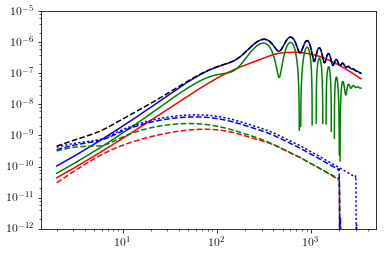

In [61]:
plt.loglog(lvecplot,(totcldeltaBsp(lvecplot))*fac,ls='-',color='r')
plt.loglog(lvecplot,(totcldeltaBxsp(lvecplot)+ totcldeltaBEtermsp(lvecplot))*fac,ls='-',color='g')
plt.loglog(lvecplot,(totcldeltaBsp(lvecplot)+totcldeltaBxsp(lvecplot) + totcldeltaBEtermsp(lvecplot))*fac,
           ls='-',color='b')

plt.loglog(lvecplot,(reiontotcldeltaBsp(lvecplot))*fac,ls='--',color='r')

plt.loglog(lvecplot,(reiontotcldeltaBxsp(lvecplot)+ 
                     reiontotcldeltaBEtermsp(lvecplot))*fac,ls='--',color='g')
plt.loglog(lvecplot,(reiontotcldeltaBsp(lvecplot)
                     +reiontotcldeltaBxsp(lvecplot)
                     + reiontotcldeltaBEtermsp(lvecplot))*fac,ls='--',color='b')

plt.loglog(lvecplot,(reiontotcldeltaBsp(lvecplot)
                     +reiontotcldeltaBxsp(lvecplot)
                     + reiontotcldeltaBEtermsp(lvecplot))*fac
           +(totcldeltaBsp(lvecplot)
                     +totcldeltaBxsp(lvecplot)
                     + totcldeltaBEtermsp(lvecplot))*fac,ls='--',color='k')

plt.loglog(lvecplot,(reionfullautoBsp(lvecplot)
                     +reionfullBEtermsp(lvecplot)
                     + reionfullBxtermsp(lvecplot))*fac,ls=':',color='b')

plt.ylim([1e-12,1e-5]);

6.14892108194e-13


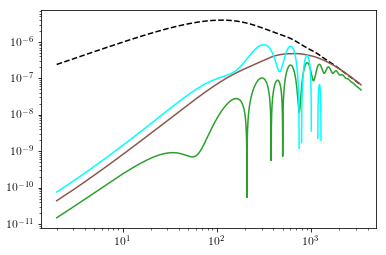

In [62]:
#Compare with high L asympotics
zetavar=np.sum(polcl_sp(np.arange(2,4000))*np.arange(2,4000))/4/np.pi
print zetavar
plt.loglog(lvecplot,4*zetavar*(cl_psi_d_sp(lvecplot))*fac,ls='--',color='k')

plt.loglog(lvecplot,(totcldeltaBsp(lvecplot))*fac,ls='-',color='C5')
plt.loglog(lvecplot,np.abs(totcldeltaBxsp(lvecplot))*fac,ls='-',color='C2')
plt.loglog(lvecplot,(totcldeltaBEtermsp(lvecplot))*fac,ls='-',color='cyan')


In [63]:
#B power in terms of delay and emission parts
delaycldeltaB = np.zeros(lsampvelcl.shape)
delaycldeltaBxlens = np.zeros(lsampvelcl.shape)
delaycldeltaBxemit = np.zeros(lsampvelcl.shape)

lstep = 5
for i, ll in enumerate(lsampvelcl):
    if ll > cl_ls[-1]//2: break
    l = np.float64(ll)
    for llp in range(2,lmax_e, lstep):
      lp = np.float64(llp)
      if abs(ll-llp)>200 and lp>200:
          nphi = 2*int(min(lp/10*acc,200))+1
      elif ll>4000:
          nphi = 2*int(lp/10*acc)+1
      else:
          nphi = 2*int(lp)+1
      dphi= 2*np.pi/nphi
      phi = np.linspace(0, (nphi-1)/2*dphi, (nphi-1)//2+1)
      w = np.ones(phi.size)
      w[1:]=2
      cosphi = np.cos(phi)
      cos2phi = np.cos(2*phi)
      sinphi = np.sin(phi)
      sin2phi = np.sin(2*phi)

      lpp = np.sqrt(lp**2+l**2- 2*cosphi*l*lp)
      w[lpp < 2]=0
      w[lpp > lmax_e]=0
      lpp[lpp==0]=1
      delaycldeltaB[i]+= lp*np.dot(w,(lp*sin2phi)**2*cl_psi_d_sp(lpp)/lpp**2)*dphi*poldelaycl_sp(lp)

      delaycldeltaBxemit[i]+= lp*np.dot(w,(sinphi*l - lp*sin2phi)*lp*
                                sin2phi*cl_psi_d_sp(lpp)/lpp**2)*dphi* poldelayemissioncl_sp(lp)

      delaycldeltaBxlens[i]+= lp*np.dot(w,lp*(sin2phi)**2*(l*cosphi-lp)*
                                 cl_psi_d_x_lens_sp(lpp)/lpp**2)*dphi* poldelayEcl_sp(lp)
        

delaycldeltaB*=lstep/(2*np.pi)**2
delaycldeltaBxemit*=4*lstep/(2*np.pi)**2
delaycldeltaBxlens*=-2*lstep/(2*np.pi)**2

delaycldeltaBsp = UnivariateSpline(lsampvelcl ,delaycldeltaB,s=0)
delaycldeltaBxlenssp = UnivariateSpline(lsampvelcl ,delaycldeltaBxlens,s=0)
delaycldeltaBxemitsp = UnivariateSpline(lsampvelcl ,delaycldeltaBxemit,s=0)


In [64]:
#look at standard lensing from reionization
clreionB = np.zeros(lsampvelcl.shape)
lstep = 1
llpmax=lmax_e//2
for i, ll in enumerate(lsampvelcl):
    if ll > cl_ls[-1]//2: break
    l = np.float64(ll)
    for llp in range(2,llpmax, lstep):
      lp = np.float64(llp)
      if abs(ll-llp)>200 and lp>200:
          nphi = 2*int(min(lp/10*acc,200))+1
      elif ll>4000:
          nphi = 2*int(lp/10*acc)+1
      else:
          nphi = 2*int(lp)+1
      dphi= 2*np.pi/nphi
      phi = np.linspace(0, (nphi-1)/2*dphi, (nphi-1)//2+1)
      w = np.ones(phi.size)
      w[1:]=2
      sin2phi = np.sin(2*phi)
      cosphi = np.cos(phi)

      lpp = np.sqrt(lp**2+l**2- 2*cosphi*l*lp)
      w[lpp < 2]=0
      w[lpp > llpmax]=0
      lpp[lpp==0]=1
      clreionB[i]+= lp*np.dot(w,(sin2phi)**2*(l*cosphi-lp)**2*reion_cl_phi_sp(lpp)/lpp**2)*dphi*EEreioncl_sp(lp)*lp**2
clreionB*=lstep/(2*np.pi)**2
clreionBsp = UnivariateSpline(lsampvelcl ,clreionB,s=0)

(1e-10, 1.0)

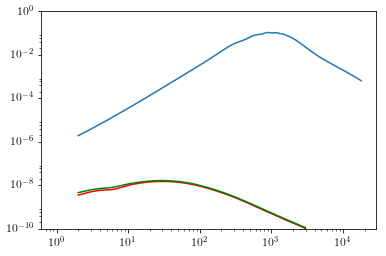

In [65]:
#lensing of reionization
fac=lvecplot*(lvecplot+1)*2.726**2*1e12/2/np.pi
plt.loglog(Ref_ls,RefCB,color='C0')
plt.loglog(lvecplot,clreionBsp(lvecplot)*fac,color='r')

plt.loglog(lvecplot,reionlensingBsp(lvecplot)*fac,color='g') #full sky

plt.ylim([1e-10,1e-0])


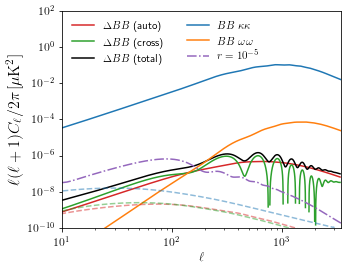

In [66]:
somefullsky=True
fig=plt.figure(figsize=(5,4))
lvecplot = np.arange(2,3401)

fac=lvecplot*(lvecplot+1)*2.726**2*1e12/2/np.pi
autocol='C3'
totcol='k'
if False:
    plt.loglog(lvecplot,(delaycldeltaBsp(lvecplot)+delaycldeltaBxemitsp(lvecplot)
                         + cldeltaBsp(lvecplot))*fac,ls='-',color=autocol)
    plt.loglog(lvecplot,(delaycldeltaBxlenssp(lvecplot) +cldeltaBxsp(lvecplot) )*fac,ls='-',color='C2')
    plt.loglog(lvecplot,(delaycldeltaBsp(lvecplot)+delaycldeltaBxemitsp(lvecplot)+delaycldeltaBxlenssp(lvecplot)
                         + cldeltaBsp(lvecplot)+cldeltaBxsp(lvecplot))*fac,ls='-',color='C3')
    
else:
    plt.loglog(lvecplot,(totcldeltaBsp(lvecplot))*fac,ls='-',color=autocol)
    plt.loglog(lvecplot,(totcldeltaBxsp(lvecplot)+ totcldeltaBEtermsp(lvecplot))*fac,ls='-',color='C2')
    if somefullsky:
        plt.loglog(lvecplot,(totcldeltaBsp(lvecplot)+totcldeltaBxsp(lvecplot) + totcldeltaBEtermsp(lvecplot)
        +reionfullautoBsp(lvecplot)+ reionfullBxtermsp(lvecplot)+ reionfullBEtermsp(lvecplot))*fac,ls='-',color=totcol)
    else:
        plt.loglog(lvecplot,(totcldeltaBsp(lvecplot)+totcldeltaBxsp(lvecplot) + totcldeltaBEtermsp(lvecplot)
        +reiontotcldeltaBsp(lvecplot)+ reiontotcldeltaBxsp(lvecplot)+ reiontotcldeltaBEtermsp(lvecplot))*fac,ls='-',color=totcol)

#    plt.loglog(lvecplot,(totcldeltaBsp(lvecplot)+totcldeltaBxsp(lvecplot) + totcldeltaBEtermsp(lvecplot))*fac,ls='-',color='C3')

plt.loglog(Ref_ls ,RefCB,color='C0')
plt.loglog(Bcurl_L,Bcurl, color='C1')

plt.loglog(np.arange(BB_tensor.size), 1e-3*BB_tensor,color='C4',ls='-.')

if somefullsky:
    plt.loglog(lvecplot,(reionfullautoBsp(lvecplot))*fac,ls='--',color=autocol, alpha=0.5)
    plt.loglog(lvecplot,(reionfullBxtermsp(lvecplot)+ reionfullBEtermsp(lvecplot))*fac,ls='--',color='C2', alpha=0.5)
    plt.loglog(lvecplot,reionlensingBsp(lvecplot)*fac,ls='--',color='C0', alpha=0.5)
else:
    plt.loglog(lvecplot,(reiontotcldeltaBsp(lvecplot))*fac,ls='--',color=autocol, alpha=0.5)
    plt.loglog(lvecplot,(reiontotcldeltaBxsp(lvecplot)+ reiontotcldeltaBEtermsp(lvecplot))*fac,ls='--',color='C2', alpha=0.5)
    plt.loglog(lvecplot,clreionBsp(lvecplot)*fac,ls='--',color='C0', alpha=0.5)

plt.xlim([10,3500])
plt.ylim([1e-10,100])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1) C_{\ell}%s$'%normtex,fontsize=16)
plt.legend([r'$\Delta BB$ (auto)',r'$\Delta BB$ (cross)', r'$\Delta BB$ (total)',
            r'$BB$ $\kappa\kappa$',r'$BB$ $\omega\omega$',r'$r=10^{-5}$'],
           loc='upper left',  ncol=2, frameon=False)
plt.savefig('BB_total_CL.pdf', bbox_inches='tight',fontsize=16);

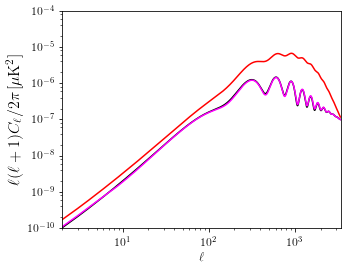

In [67]:
#Check consistency of the two ways of adding up to the total signal
fig=plt.figure(figsize=(5,4))
lvecplot = np.arange(2,3401)

fac=lvecplot*(lvecplot+1)*2.726**2*1e12/2/np.pi

plt.loglog(lvecplot,(cldeltaBsp(lvecplot))*fac,ls='-',color='red')

plt.loglog(lvecplot,(totcldeltaBsp(lvecplot)+totcldeltaBxsp(lvecplot) + totcldeltaBEtermsp(lvecplot))*fac,ls='-',color='k')

plt.loglog(lvecplot,(delaycldeltaBsp(lvecplot)+delaycldeltaBxemitsp(lvecplot)+delaycldeltaBxlenssp(lvecplot)
                     + cldeltaBsp(lvecplot)+cldeltaBxsp(lvecplot) )*fac,ls='-',color='magenta')

plt.loglog(lvecplot,(delaycldeltaBsp(lvecplot)+delaycldeltaBxemitsp(lvecplot)+0*delaycldeltaBxlenssp(lvecplot))*fac,ls='-',color='green')


plt.xlim([2,3500])
plt.ylim([1e-10,1e-4])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1) C_{\ell}%s$'%normtex,fontsize=16);


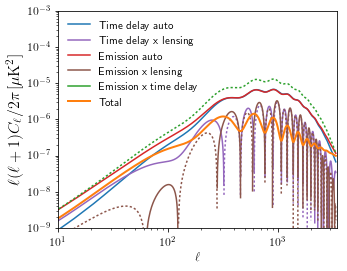

In [68]:
#delay (green)  vs emission (red) only
fig=plt.figure(figsize=(5,4))

#plt.loglog(lvecplot,(delaycldeltaBsp(lvecplot)+delaycldeltaBxlenssp(lvecplot))*fac,ls='-',color='green')
plt.loglog(lvecplot,(delaycldeltaBsp(lvecplot))*fac,ls='-',color='C0', label='Time delay auto')
plt.loglog(lvecplot,(delaycldeltaBxlenssp(lvecplot))*fac,ls='-',color='C4', label='Time delay x lensing')
plt.loglog(lvecplot,-(delaycldeltaBxlenssp(lvecplot))*fac,ls=':',color='C4')

#plt.loglog(lvecplot,(cldeltaBsp(lvecplot)+cldeltaBxsp(lvecplot) )*fac, ls='-',color='red')
plt.loglog(lvecplot,(cldeltaBsp(lvecplot) )*fac, ls='-',color='C3', label='Emission auto')
plt.loglog(lvecplot,(cldeltaBxsp(lvecplot) )*fac, ls='-',color='C5', label='Emission x lensing')
plt.loglog(lvecplot,-(cldeltaBxsp(lvecplot) )*fac, ls=':',color='C5')

plt.loglog(lvecplot,(delaycldeltaBxemitsp(lvecplot) )*fac, ls='-',color='C2', label='Emission x time delay')
plt.loglog(lvecplot,-(delaycldeltaBxemitsp(lvecplot) )*fac, ls=':',color='C2')

plt.loglog(lvecplot,(delaycldeltaBsp(lvecplot)+delaycldeltaBxemitsp(lvecplot)+delaycldeltaBxlenssp(lvecplot)
                     + cldeltaBsp(lvecplot)+cldeltaBxsp(lvecplot) )*fac,ls='-',color='C1',lw=2, label='Total')

plt.xlim([10,3500])
plt.ylim([1e-9,1e-3])
plt.legend(frameon=False)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1) C_{\ell}%s$'%normtex,fontsize=16)
#plt.loglog(lvecplot,-(exacttotcldeltaBx2sp(lvecplot))*fac,ls='--',color='green')
plt.savefig('BB_terms_CL.pdf', bbox_inches='tight',fontsize=16)

In [69]:
whiteBBtotauto = np.dot(intls,polcl_sp(intls)*cl_psi_d_sp(intls))/np.pi/4
whiteBBtotcross = -2*np.dot(intls,EEnoreioncl_sp(intls)*cl_psi_d_x_lens_sp(intls))/4/np.pi
whiteBBtot = whiteBBtotauto+whiteBBtotcross
print 'White approx auto:', whiteBBtotauto*2.726**2*1e12
print 'White approx cross:', whiteBBtotcross*2.726**2*1e12
print 'White approx total:',whiteBBtot*2.726**2*1e12
Llow = 80
print 'actual tot:', (delaycldeltaBsp(Llow)+delaycldeltaBxemitsp(Llow)+delaycldeltaBxlenssp(Llow)
                     + cldeltaBsp(Llow)+cldeltaBxsp(Llow))*2.726**2*1e12
print 'actual tot:', (totcldeltaBsp(Llow)+ totcldeltaBxsp(Llow) + totcldeltaBEtermsp(Llow))*2.726**2*1e12
print 'actual auto:', (totcldeltaBsp(Llow))*2.726**2*1e12
print 'actual cross:', (totcldeltaBxsp(Llow) + totcldeltaBEtermsp(Llow))*2.726**2*1e12
print 'noise auto eff = ', np.sqrt(whiteBBtotauto*2.726**2*1e12)*180*60/np.pi

White approx auto: 4.55499902213e-11
White approx cross: 7.88251998722e-11
White approx total: 1.24375190094e-10
actual tot: 1.13753542853e-10
actual tot: 1.16328731936e-10
actual auto: 4.5141217639e-11
actual cross: 7.11875142966e-11
noise auto eff =  0.0232016048951


In [70]:
print 'Including reionization cross', -2*np.dot(intls,CEsp(intls)*cl_psi_d_x_lens_sp(intls))/4/np.pi

Including reionization cross 3.90536840983e-10


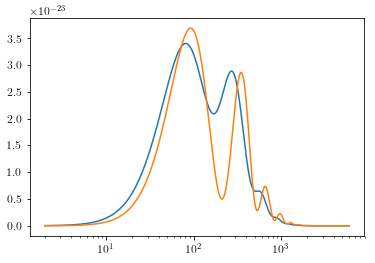

In [71]:
#Where to the contributions come from?
plt.semilogx(intls,intls**2*polcl_sp(intls)*cl_psi_d_sp(intls))
plt.semilogx(intls,-intls**2*EEnoreioncl_sp(intls)*cl_psi_d_x_lens_sp(intls))

In [72]:
#Full sky formula
from camb import threej
totautoB = np.zeros(lsampvelcl.shape)
totBEterm = np.zeros(lsampvelcl.shape)
totBxterm= np.zeros(lsampvelcl.shape)

lstep=5
lsarr=np.arange(2,lmax_e+1)
llp1=(lsarr*(lsarr+1.))
cdd = cl_psi_d_sp(lsarr)*(lsarr+2.)*(lsarr-1)*(2*lsarr+1)
cd = cl_psi_d_sp(lsarr)/llp1*(2*lsarr+1)
cxdd = cl_psi_d_x_lens_sp(lsarr)*(2*lsarr+1)
cxd = cxdd/llp1
cEE= EEnoreioncl_sp(lsarr)*(2*lsarr+1) #raw CL
cEx = polEcl_sp(lsarr)*(2*lsarr+1)
cExx = cEx/llp1
czeta = polcl_sp(lsarr)/llp1*(2*lsarr+1) 

for i, ll in enumerate(lsampvelcl):
    l = np.float64(ll)
    for llp in range(2,lmax_e, lstep):
        lp = np.float64(llp)
        wig = threej(llp,ll,2,-2)
        minl=np.abs(llp-ll)
        if minl<2:
            wig = wig[2-minl:]
        
        wigx = threej(llp,ll,0,-2)
        minl = max(2,np.abs(llp-ll))
        maxl= min(lmax_e,np.abs(llp+ll))
        off=0
        if (minl+llp+ll)%2==0: off=1
        wig2=wig[off:maxl-minl+1:2]**2
        totautoB[i]+= np.dot(wig2,czeta[minl+off-2:maxl+1-2:2])*cdd[llp-2]
        totBEterm[i]+= np.dot(wig2,cd[minl+off-2:maxl+1-2:2]
                      - cxdd[minl+off-2:maxl+1-2:2]
                      - (lp*(lp+1)-ll*(ll+1))*cxd[minl+off-2:maxl+1-2:2] )*cEE[llp-2]
        wigx2 = wigx[off:maxl-minl+1:2]*wig[off:maxl-minl+1:2]
        totBxterm[i] += (np.dot(wigx2,
                               cExx[minl+off-2:maxl+1-2:2])*(2* cd[llp-2]
                                - ((lp*(lp+1)-ll*(ll+1))*cxd[llp-2])) 
                         -np.dot(wigx2,cEx[minl+off-2:maxl+1-2:2] )*cxd[llp-2] )*np.sqrt(
                                        lp*(lp+1)*(lp+2)*(lp-1))
                                    
        

totautoB*=lstep/(4*np.pi)
totautoBsp = UnivariateSpline(lsampvelcl ,totautoB,s=0)
totBEterm*=lstep/(4*np.pi)
totBEtermsp = UnivariateSpline(lsampvelcl ,totBEterm,s=0)
totBxterm*=lstep/(4*np.pi)
totBxtermsp = UnivariateSpline(lsampvelcl ,totBxterm,s=0)

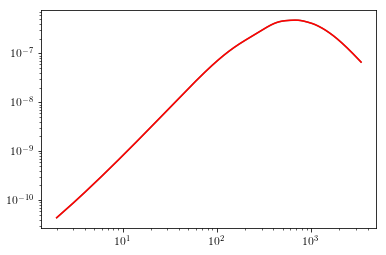

In [73]:
#compare full and flat sky
fac=lvecplot*(lvecplot+1)*2.726**2*1e12/2/np.pi
plt.loglog(lvecplot,(totcldeltaBsp(lvecplot))*fac,ls='-',color='C5')
plt.loglog(lvecplot,(totautoBsp(lvecplot))*fac,ls='-',color='red');

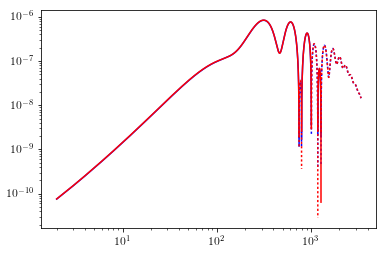

In [74]:
plt.loglog(lvecplot,totcldeltaBEtermsp(lvecplot)*fac, color='b')
plt.loglog(lvecplot,-totcldeltaBEtermsp(lvecplot)*fac, color='b', ls=':')

plt.loglog(lvecplot,totBEtermsp(lvecplot)*fac, color='r')
plt.loglog(lvecplot,-totBEtermsp(lvecplot)*fac, ls=':', color='r')
